# Featurizing Toxic Comments Using Pre-Trained Word Vectors and a Language Model's Encoder

## Overview

This notebook provides an analysis of featurization methods for text. The central idea we examine is that we can represent text (words, phrases, and even entire sentences or paragraphs) as vectors. However, we'll see that some vector representations may provide more semantic information than others. 

## Pre-Trained Word Vectors

As a first foray we featurize our data using publically available pre-trained word vectors. There are numerous word vectors available, the most common being [Word2Vec](https://code.google.com/archive/p/word2vec/), [GloVe](https://nlp.stanford.edu/projects/glove/), and [fasttext](https://github.com/facebookresearch/fastText/). We'll use the **GloVe** vectors trained on Wikipedia and Gigaword 5. 

Our input dataset contains a variable sequence of tokens (words), which we vectorize into a list of real-valued vectors. In order to use a machine learning model with such a representation we need to transform it into a fixed-vector representation. We can do this by many different aggregation schemes: sum/mean, max, min, etc. For this notebook we simply utilize unweighted averages of all the tokens, but you'll likely find that for some applications it may be more useful to consider max/min in addition, and concatenate multiple representations.


![](https://image.slidesharecdn.com/starsem-170916142844/95/yejin-choi-2017-from-naive-physics-to-connotation-modeling-commonsense-in-frame-semantics-83-638.jpg?cb=1505572199)

_image credit: Yejin Choi - 2017 - From Naive Physics to Connotation: Modeling Commonsense in Frame Semantics_

_quote credit: Ray Mooney_


## Language Model Encoders

We'll then examine a more advanced method of featurizing our sequence of tokens. In particular, we'll use the encoder from a pre-trained language model. The encoder is a fixed-length vector representation that is typically the last hidden vector in a recurrent neural network trained for machine translation or language modeling.


![](http://ruder.io/content/images/2018/07/lm_objective.png)

_image credit: Seabstain Ruder and TheGradient: NLP's ImageNet moment has arrived_

Our hope is that rather than naively aggregating our word vectors by their average representation, the last hidden layer will contain contextual information from the entire sequence of tokens.





### Imports:

We import our dataset of comments to Wikipedia page-edits from our helper `load_data`. We'll also import a dictionary of GloVe vectors and a helper function for using it to lookup word vectors for our tokenized comments:

In [1]:
from load_data import load_wiki_attacks, load_attack_encoded
from load_data import tokenize, create_glove_lookup, download_glove
import pathlib
import pandas as pd
import numpy as np
import csv
data_dir = pathlib.Path.home() / "active-learning-workshop" / "text_featurization" / "data"
if not data_dir.parent.exists():
    data_dir.parent.mkdir(parents=True)

/anaconda/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/anaconda/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/tensorflow/li

We use the [spaCy](https://spacy.io/) library to tokenize our text, but aside from some prior data cleanup there's nothing fancy happening in preprocessing.

In [2]:
glove_src =  str(data_dir / "glove.6B.300d.txt")

if not pathlib.Path(glove_src).exists():
    download_glove()
glove_lookup = create_glove_lookup(glove_src)
toxic_df = load_wiki_attacks()
toxic_df = tokenize(toxic_df, "comment_text")
toxic_df.loc[:5, ['comment_text', "tokens"]]

/anaconda/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


,comment_text,tokens
0,This is not creative . Those are the diction...,"[ , This, is, not, creative, ., Those, are, t..."
1,the term standard model is itself less NPO...,"[ , the, term, standard, model, is, itself,..."
2,"True or false, the situation as of March 200...","[ , True, or, false, ,, the, situation, as, o..."
3,"Next, maybe you could work on being less conde...","[Next, ,, maybe, you, could, work, on, being, ..."
4,This page will need disambiguation.,"[This, page, will, need, disambiguation, .]"
5,Important note for all sysops There is a b...,"[ , Important, note, for, all, sysops, Ther..."


### Vectorize with GloVe:

We can use our `glove_lookup` dictionary to vectorize all the tokens in our text. We apply the function to every token in our comment, and then take the average over all word vectors. Again, you should definitely consider other aggregation methods such as max/min.

In [3]:
toxic_df['glove_aggregate'] = toxic_df.tokens.apply(lambda x: np.mean([glove_lookup[v] for v in x], axis=0)) 

In [4]:
toxic_df.loc[:5, ["comment_text", "tokens", "glove_aggregate"]]

,comment_text,tokens,glove_aggregate
0,This is not creative . Those are the diction...,"[ , This, is, not, creative, ., Those, are, t...","[-0.1499181361726886, 0.05423158062295079, -0...."
1,the term standard model is itself less NPO...,"[ , the, term, standard, model, is, itself,...","[-0.1587900504010778, 0.013006055911443676, -0..."
2,"True or false, the situation as of March 200...","[ , True, or, false, ,, the, situation, as, o...","[-0.12243446450199647, -0.06342039171645089, 0..."
3,"Next, maybe you could work on being less conde...","[Next, ,, maybe, you, could, work, on, being, ...","[-0.12554458174387909, 0.0733292975111634, -0...."
4,This page will need disambiguation.,"[This, page, will, need, disambiguation, .]","[-0.3239130127453462, -0.058272738777694545, -..."
5,Important note for all sysops There is a b...,"[ , Important, note, for, all, sysops, Ther...","[-0.12507687575733267, 0.06996425342205934, -0..."


## Language Model 

Our language model encoder utilizes pre-trained language models hosted on [TensorFlow Hub](https://www.tensorflow.org/hub/modules/text). 

Our helper script `encoder.py` provides a simple class entitled `encoder` with methods for encoding text using three different encoder models: [ELMO](http://www.aclweb.org/anthology/N18-1202), [USE](https://arxiv.org/pdf/1803.11175.pdf), and [NNLM](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). 

### Encoder Imports:

The class is a bit verbose for readability, but it's conceptually very simple. We load the pre-trained module, which defines a static computational graph with the learned weights from the language model on it's dataset. We initialize this computational graph into a Keras session, which we can then use for fine-tuning or for featurizing an input sequence by computing a forward pass of the computational graph. Note, we could have also just used `tensorflow` directly to do the model building and training, but Keras has some helpful utilities for data min-batching and pre-fetching that makes this very easy (at the cost of some incompatibilities: [issues with fine-tuning may arise](https://groups.google.com/a/tensorflow.org/forum/#!topic/hub/Y4AdAM7HpX0).

In [5]:
from encoder import encoder

Using TensorFlow backend.


In [6]:
??encoder

Init signature: encoder(model='elmo', trainable=False, num_labels=2)
Docstring:      <no docstring>
Source:        
class encoder():


    def __init__(self, model="elmo", trainable=False, num_labels=2):
        """Defines an encoder using a pre-trained TensorflowHub module. 
        Can be used for featurization or fine-tuned for classification.
        
        Parameters
        ----------
        model : str, optional
            Trained model from tfhub to use (the default is "elmo")
        trainable : bool, optional
            Whether to fix weights or make them trainable (the default is False)
        num_labels : int, optional
            Number of labels in target class, applicable for classification (the default is 2)

        Raises
        ------
        NotImplementedError
            If self.model not in ["elmo", "nnlm", "use"]
        
        """


        super(encoder, self).__init__()
        # Create a TensorFlow Session and run initializers
        self.session =

### Featurized Dataset

Here's an example usage of converting the `comment_text` into a fixed sequence using our encoder and the **Universal Sentence Encoder**:


```python

use_encoder = encoder(model="use")
featurizer = use_encoder.transform_model()
featurizer.summary()

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    transformed_review = featurizer.predict(toxic_df.comment_text.values, batch_size=64)
```

This operation will take some time, ~1.5 hours on a machine with 16 cores. We have a pre-featurized version of this dataset already saved for you, which you can download using our helper functions:

In [7]:
encoded_attacks = load_attack_encoded()
toxic_df['encoded_comment'] = encoded_attacks.values.tolist()

In [8]:
toxic_df.loc[:5, ['comment_text', 'encoded_comment']]

,comment_text,encoded_comment
0,This is not creative . Those are the diction...,"[0.026781896, -0.05754256, 0.033774074, 0.0097..."
1,the term standard model is itself less NPO...,"[0.011424046, -0.009576778000000001, -0.026437..."
2,"True or false, the situation as of March 200...","[0.00041413374, 0.08557465, 0.024096673, -0.09..."
3,"Next, maybe you could work on being less conde...","[0.058229163, 0.048170675, -0.054312646, 0.029..."
4,This page will need disambiguation.,"[0.05511004, 0.017830834, -0.08593257, -0.0343..."
5,Important note for all sysops There is a b...,"[0.07102389, 0.029018747, -0.04301559, -0.0764..."


## Model Evaluation

How do these features compare on discrimaniting between toxic / non-toxic comments? Let's put them in a raceoff.

## Sklearn Imports:

In [9]:
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, make_scorer

lb = LabelBinarizer()
train_sizes = np.arange(0.1, 1.1, 0.1)

estimator = LogisticRegression()
# estimator = GaussianNB()
# estimator = RandomForestClassifier()

def featurize(df=toxic_df):

    labels = np.concatenate(lb.fit_transform(df.is_attack.values))
    glove_features = np.vstack(df.glove_aggregate.values)
    use_features = np.vstack(df.encoded_comment.values)

    return labels, glove_features, use_features

labels, glove_features, use_features = featurize()

## Learning Curves:

Learning curves allows us to visualize the performance of the system as a function of the amount of examples it's seen. We first create learning curves using the `glove_features`, and then we create learning curves of the `encoded_features`. We plot them together so we can compare:

In [10]:
%%time
g_train_sizes, g_train_scores, g_test_scores = learning_curve(estimator=estimator, 
                                                              X=glove_features,
                                                              y=labels, 
                                                              scoring=make_scorer(roc_auc_score),
                                                              n_jobs=8, train_sizes=train_sizes)

CPU times: user 14.3 s, sys: 706 ms, total: 15 s
Wall time: 21.4 s


In [11]:
%%time
e_train_sizes, e_train_scores, e_test_scores = learning_curve(estimator=estimator, 
                                                              X=use_features,
                                                              y=labels, 
                                                              scoring=make_scorer(roc_auc_score),
                                                              n_jobs=8, train_sizes=train_sizes)

CPU times: user 23.9 s, sys: 1.24 s, total: 25.1 s
Wall time: 39.8 s


### Results

We used AUC as our scoring criteria, but you could also use accuracy.

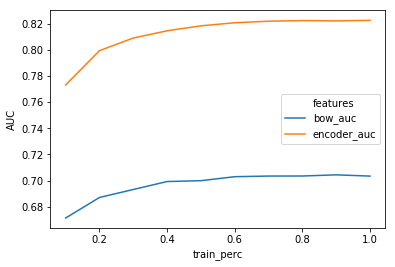

In [13]:
import seaborn as sns
%matplotlib inline

results_df = pd.DataFrame({"train_perc": train_sizes,
                           "bow_auc": np.mean(g_test_scores, axis=1),
                           "encoder_auc": np.mean(e_test_scores, axis=1)})

sns.lineplot(x="train_perc", y="AUC", hue="features", 
             data=results_df.melt("train_perc", var_name="features", value_name="AUC"), 
            )

### Discussion:

The encoder features outperform the bag-of-words (BoW) glove vectors at every level of training data experience. While a more careful aggregation procedure of the word vectors would have done much better (in fact, there's good evidence that a thoughtful weighted-average can be [very hard to beat](https://openreview.net/forum?id=SyK00v5xx) on many discriminative tasks), the main point of this analysis is that using pre-trained encoders can basically be a drop-in replacement for word vectors for many applications and give significant gains, _modulo_ additional computation time to featurize the dataset (the BoW approach uses a lookup to compute features, which is very fast, whereas the encoder approach requires a full forward pass through a complicated recurrent neural network, which are inherently sequential (this is why there is a greater push towards [feed-forward architectures for language modeling](https://blog.openai.com/language-unsupervised/), which can be much faster during training and evaluation time).

## Error Analysis __WARNING: FOUL LANGUAGE AHEAD__:

Let's see some examples of where our model using language model features outperformed our BoW model. We'll be a bit more fair to both models this time and do a quick grid search to find a well-optimized model:

In [15]:
model_df = toxic_df.loc[:,['is_attack', 'comment_text', 'glove_aggregate', 'encoded_comment']]
from sklearn.model_selection import train_test_split, GridSearchCV
train_df, test_df = train_test_split(model_df, train_size=0.75)

def cv_predict_eval():

    cv = GridSearchCV(RandomForestClassifier(),
                     param_grid={
                         'n_estimators': [10, 100],
                         'max_features': ['sqrt', 'log2'],
                         'max_depth': [3, 5, None]}, 
                      refit=True, 
                      n_jobs=20)


    labels, glove_features, use_features = featurize(train_df)
    labels_test, glove_test, use_test = featurize(test_df)

    glove_cv = cv.fit(glove_features, labels)
    glove_hat = cv.predict(glove_test)
    use_cv = cv.fit(use_features, labels)
    use_hat = cv.predict(use_test)

    results_df = test_df
    results_df['use_pred'] = use_hat
    results_df['glove_pred'] = glove_hat

    return results_df

results_df = cv_predict_eval()

/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Where BoW-GloVe Fails and the Encoder Succeeds:

In [16]:
results_df.loc[(results_df["is_attack"] == results_df["use_pred"]) & 
               (results_df["is_attack"] != results_df["glove_pred"]) & 
               (results_df["is_attack"] == False), 
               ["comment_text", "is_attack"]]

,comment_text,is_attack
26284,See http www.stella doro.com contact.asp,False
91167,sound right coming out of your mouth,False
23154,BUT...BUT...THAT WAS THEIR REACTION,False
115045,on Rogers Communications,False
44226,You think you re smarter than NATO or Romanian...,False
38194,Urrrppp You wanna have my love Burp,False
101589,"Rorquals oh sorry, I don t think you know w...",False
93592,"cAN YOU BAN ME well, can you",False
86609,MY NAME IS ADAM SMITH AND I AM VERY LIKE A GO...,False
78974,Why do you keep reverting a perfectly reaso...,False


In [17]:
results_df.loc[[25534], "comment_text"].values

array([' ok ...sorry thougt it was fun wont do it again ill use the dumb sandbox or w e'],
      dtype=object)

### Discussion:

It's unfortunately pretty challenging to find any civil discussion on online forums. In the example highlighted above our BoW approach predicted the comment to be an attack, whereas the encoder correctly predicted it as benign. The prevalence of terms such "dumb", "sorry" _bias_ the average word vector to a representation that is more likely to be an attack than a nice comment, whereas the language model is able to encode the sequence of representations more accurately. A more acute example of this phenomena arises with swear words (ommitted here, but see for example record index `[105512]` for an example where the single occurrence of a curse word causes the BoW classifier to misclassify the sentiment dramatically (but the encoder gets it right). This also arises frequently in the use of **negation** in sentiment analysis.